# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from collections import Counter

from torchinfo import summary
import utils

In [4]:
import sys

DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [5]:
BATCH_SIZE = 256  # tamaño del batch

## Cargamos datos + EDA


In [7]:
TRAIN_DATA_PATH = "mitbih_train.csv"
TEST_DATA_PATH = "mitbih_test.csv"

In [27]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

df_train = df_train.dropna()
df_test = df_test.dropna()

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

In [28]:
print(f"El dataset cuenta con {df.iloc[:,-1].nunique()} clases distintas")

El dataset cuenta con 5 clases distintas


In [29]:
TARGET_NAMES = [
    "Normal",
    "Arritmia supraventricular",
    "Arritmia ventricular",
    "Latido fusionado",
    "Latido desconocido",
]


187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: title={'center': 'Número de muestras por clase'}, xlabel='187'>

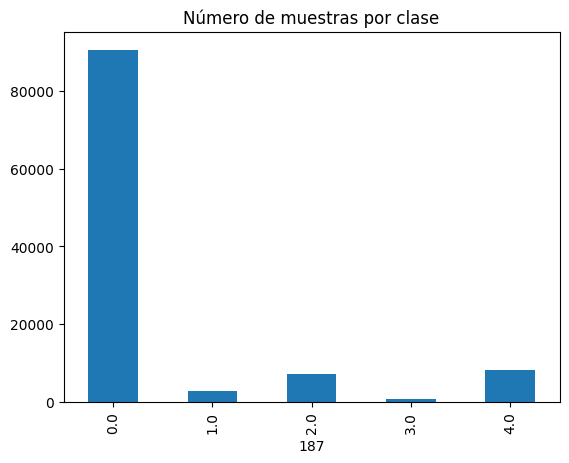

In [30]:
class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar", title="Número de muestras por clase")

In [31]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df.iloc[:, -1]),
    y=df.iloc[:, -1]
)

# Convert to a dictionary for easier use
class_weights_dict = dict(zip(np.unique(df.iloc[:, -1]), class_weights))
print("Class weights:")
print(class_weights_dict)

# Convert to tensor for use with PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("\nClass weights tensor:")
print(class_weights_tensor)

Class weights:
{np.float64(0.0): np.float64(0.2416319862234929), np.float64(1.0): np.float64(7.876646275638719), np.float64(2.0): np.float64(3.0250414593698176), np.float64(3.0): np.float64(27.259277708592776), np.float64(4.0): np.float64(2.722875979599453)}

Class weights tensor:
tensor([ 0.2416,  7.8766,  3.0250, 27.2593,  2.7229], device='cuda:0')


Creamos la clase MITBIHDataSet

In [32]:
class MITBIHDataSet(Dataset):
    def __init__(self, df_features, df_target, num_classes):
        self.x_df = df_features.values
        self.y_df = df_target.values
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

In [52]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [53]:
SEED = 23

In [54]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

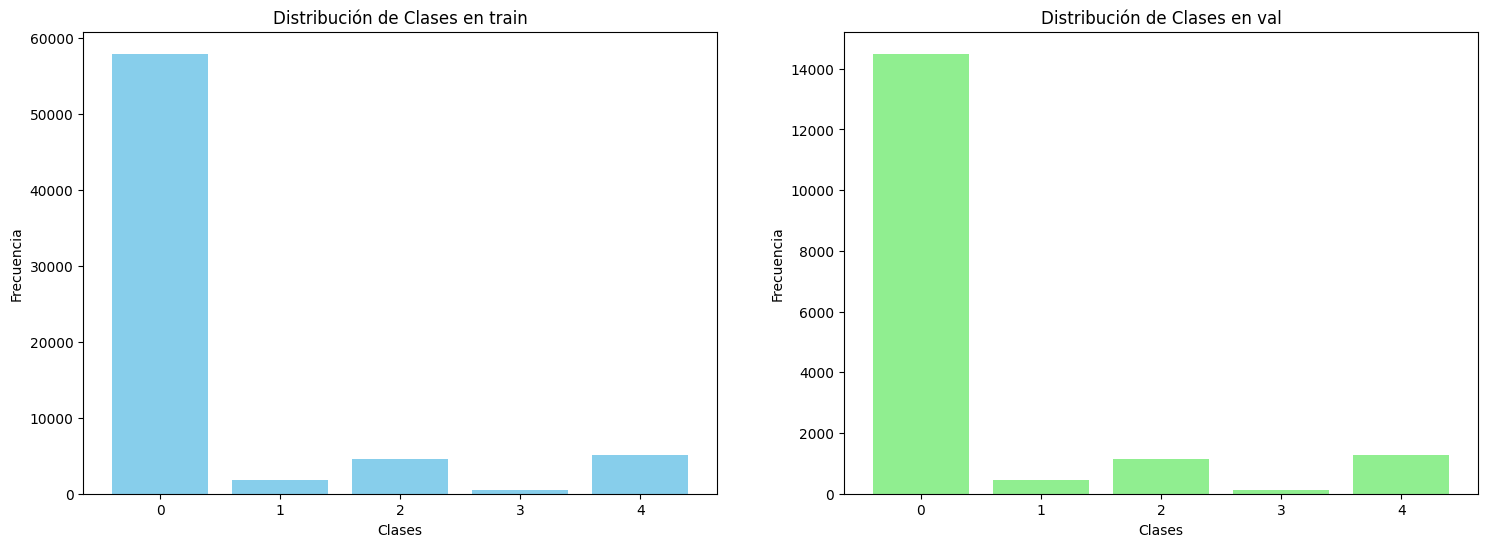

In [55]:
# Contar la frecuencia de cada clase en cada conjunto
class_counts_train = y_train.value_counts()
class_counts_val = y_val.value_counts()

# Crear subplots para los histogramas
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma para train
axes[0].bar(class_counts_train.index, class_counts_train.values, color="skyblue")
axes[0].set_title("Distribución de Clases en train")
axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Frecuencia")

# Histograma para val
axes[1].bar(class_counts_val.index, class_counts_val.values, color="lightgreen")
axes[1].set_title("Distribución de Clases en val")
axes[1].set_xlabel("Clases")
axes[1].set_ylabel("Frecuencia")

plt.show()

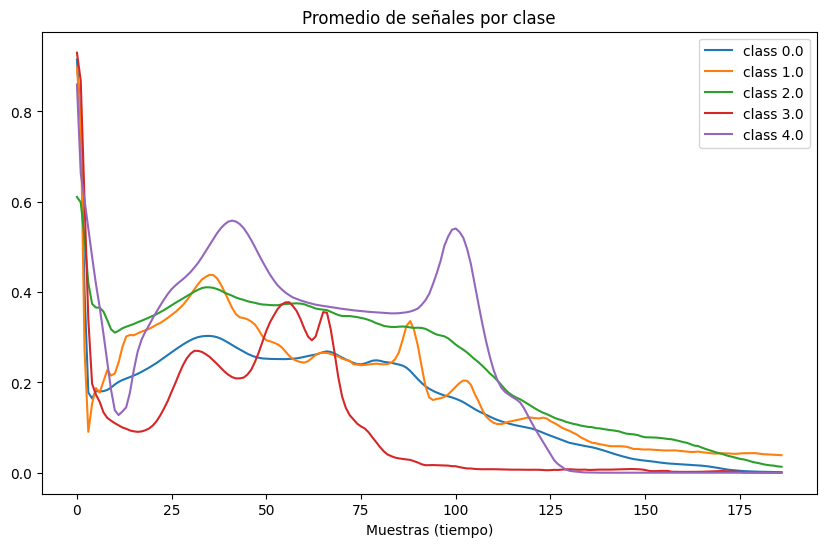

In [58]:
plt.figure(figsize=(10,6))
classes_to_plot = [0.0,1.0,2.0,3.0,4.0]

# Combine X_train and y_train for easier grouping
train_combined = X_train.copy()
train_combined['target'] = y_train

for c in classes_to_plot:
    # Select samples for the current class and calculate the mean
    average_sample = train_combined[train_combined['target'] == c].iloc[:, :-1].mean(axis=0)
    plt.plot(average_sample, label=f'class {c}')

plt.legend()
plt.title('Promedio de señales por clase')
plt.xlabel('Muestras (tiempo)')
plt.show()

In [61]:
nclasses = y_train.unique().shape[0]
print(f"Hay {nclasses} clases")

Hay 5 clases


In [62]:
train_dataset = MITBIHDataSet(X_train, y_train, nclasses)
val_dataset = MITBIHDataSet(X_val, y_val, nclasses)
test_dataset = MITBIHDataSet(X_test, y_test, nclasses)

In [63]:
def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [64]:
train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE
)

In [90]:
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, (h, c) = self.lstm(x)      # out: (B, 187, H*d)
        last = out[:, -1, :]            # o bien: h[-1] (ver nota abajo)
        return self.fc(last)

class ECG_GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, h = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)

# Instanciar modelo de ejemplo
model = ECG_LSTM().to(DEVICE)
model_2 = ECG_GRU().to(DEVICE)
print(model)
print(model_2)

ECG_LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=5, bias=True)
  )
)
ECG_GRU(
  (gru): GRU(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [91]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [92]:
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
criterion_2 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [93]:
utils.train(model,optimizer,criterion,train_loader,val_loader,DEVICE)

Epoch: 001 | Train Loss: 1.60583 | Val Loss: 1.57560
Epoch: 002 | Train Loss: 1.56932 | Val Loss: 1.54824
Epoch: 003 | Train Loss: 1.48657 | Val Loss: 1.29925
Epoch: 004 | Train Loss: 1.23491 | Val Loss: 1.18227
Epoch: 005 | Train Loss: 1.18868 | Val Loss: 1.18741
Epoch: 006 | Train Loss: 1.13228 | Val Loss: 1.09603
Epoch: 007 | Train Loss: 1.14113 | Val Loss: 1.13303
Epoch: 008 | Train Loss: 1.14136 | Val Loss: 1.14538
Epoch: 009 | Train Loss: 1.11271 | Val Loss: 1.04541
Epoch: 010 | Train Loss: 1.11392 | Val Loss: 1.09529


([1.6058342404609178,
  1.5693185842820327,
  1.4865723034761247,
  1.2349106216952748,
  1.1886778530413218,
  1.132280234002719,
  1.141130530921212,
  1.1413551853956097,
  1.112711390222076,
  1.1139174205978422],
 [1.57559659515602,
  1.548236432282821,
  1.2992529402608457,
  1.1822666309881902,
  1.187408981979757,
  1.096027940943621,
  1.1330321379329846,
  1.1453750055769216,
  1.0454059130903604,
  1.0952859374060147])

In [94]:
utils.train(model_2,optimizer_2,criterion_2,train_loader,val_loader,DEVICE)

Epoch: 001 | Train Loss: 1.59481 | Val Loss: 1.55413
Epoch: 002 | Train Loss: 1.46267 | Val Loss: 1.31748
Epoch: 003 | Train Loss: 1.25400 | Val Loss: 1.18864
Epoch: 004 | Train Loss: 1.22305 | Val Loss: 1.17264
Epoch: 005 | Train Loss: 1.15605 | Val Loss: 1.10741
Epoch: 006 | Train Loss: 1.11645 | Val Loss: 1.02422
Epoch: 007 | Train Loss: 0.99508 | Val Loss: 0.93848
Epoch: 008 | Train Loss: 0.90584 | Val Loss: 0.78777
Epoch: 009 | Train Loss: 0.83637 | Val Loss: 0.75114
Epoch: 010 | Train Loss: 0.76527 | Val Loss: 0.70214


([1.5948118523959696,
  1.4626659424635615,
  1.254002082304363,
  1.2230483239149526,
  1.1560492319782285,
  1.1164524420334474,
  0.9950811062416021,
  0.9058371925876089,
  0.8363708114101939,
  0.7652697167257323],
 [1.5541277398233828,
  1.3174785220104714,
  1.1886410402215046,
  1.1726402407107146,
  1.1074077892994536,
  1.0242217131282971,
  0.9384780647098154,
  0.7877678188724794,
  0.7511423104915066,
  0.7021362699460292])